# Topic Models - Case Study

For Topic Models, refer to [`codex/py/NLP/Topic Models - Food Safety.ipynb`]

# 1. Load Data & Create Dataset

In [1]:
import zipfile
import io
import os.path
import pandas as pd

with zipfile.ZipFile('FoodSafetyAriticles.zip', 'r') as z:
    for filename in z.namelist(): 
        
        # 解压h5文件
        if (os.path.isfile(filename) == False):
            z.extract(filename)
        
        # 加载h5文件
        with pd.HDFStore(filename,  mode='r') as newstore:
            df = newstore.select('df')
z.close()

C:\Users\eleve\Anaconda3\lib\site-packages\tables\leaf.py:410: PerformanceWarning: The Leaf ``/df/_i_table/content/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [2]:
print(df.groupby(['label'])['label'].count())

label
人才        44
体育       200
卫生       101
娱乐       108
房产        66
教育        58
汽车        42
电脑       210
科技        75
财经        47
食品安全    4648
Name: label, dtype: int64


In [3]:
# 构造多分类数据集

df_food = df[df['label'] == '食品安全'].sample(frac=0.04)
#print(df_food.count())
df_others = df[df['label'] != '食品安全']
#print(df_others.count())
df_train_n = df_food.append(df_others)
#print(df_train_n.count())
print(df_train_n.groupby(['label'])['label'].count())

label
人才       44
体育      200
卫生      101
娱乐      108
房产       66
教育       58
汽车       42
电脑      210
科技       75
财经       47
食品安全    186
Name: label, dtype: int64


# 2. Bag of Word

The BoW model captures the frequencies of the word occurrences in a text corpus.
e.g., BOW(doc_1): [1,1,1,2,1,1,0,0]

## 2.1 Stop Words

In [4]:
%run get_stop_words.py
stpwrdlst = get_stop_words()
print(len(stpwrdlst))

2680


## 2.2 Get BoW vector from text

后面测试数据用到

In [16]:
import jieba

# Get histogram
def word_frequency(s, stpwrdlst):
    jieba.add_word('气相色谱')
    jieba.add_word('液相色谱')
    jieba.add_word('区块链')
    jieba.add_word('打call')
    jieba.add_word('一物一码')
    wordfreq = {}
    wordlist = list(jieba.cut(s, cut_all=False))
    for w in set(wordlist):
        if w not in stpwrdlst:            
            wordfreq[w] = wordlist.count(w)
            
    return wordfreq

In [ ]:
def doc2bow(s, stpwrdlst, vocab):
    wf = word_frequency(s, stpwrdlst)
    a = np.zeros(len(vocab))
    for i,w in enumerate(vocab):
        if w in wf.keys():
            a[i] = wf[w]
    return a 

## 2.3 DTM (Document-Term Matrix)

In [ ]:
# %load DTM_CHN.py
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import jieba

# get DTM for Chinese. The special treatment is add space between Chinese words. 
# The returned corpus can be used by sklearn  TfidfVectorizer, CountVectorizer
def DTM_CHN(texts, addwrdlst = [], stpwrdlst = []):    

    for w in addwrdlst:
        jieba.add_word(w)    

    newcorpus = []

    for text in tqdm(texts):    
        words = list(jieba.cut(text, cut_all = False))    
        filtered = [item for item in words if item not in stpwrdlst]
        newtext = " ".join(filtered)
        newcorpus.append(newtext)

    # newcorpus = [" ".join(list(jieba.cut(t, cut_all = False))) for t in corpus]
    # print(newcorpus[0])

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(newcorpus)
    vocab = vectorizer.get_feature_names()
    
    return newcorpus, X, vocab

In [5]:
# %run DTM_CHN.py
_, X, vocab = DTM_CHN(df_train_n['content'].values, ['气相色谱','液相色谱','区块链','打call','一物一码'] ,stpwrdlst)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\eleve\AppData\Local\Temp\jieba.cache
Loading model cost 0.616 seconds.
Prefix dict has been built successfully.
100%|██████████████████████████████████████████████████████████████████████████████| 1137/1137 [00:21<00:00, 52.03it/s]


# 2 训练模型

设置11个主题

In [6]:
import lda

n_topics = 11

model = lda.LDA(n_topics = n_topics, n_iter = 2000)  
Xt = model.fit_transform(X) # is also available 

INFO:lda:n_documents: 1137
INFO:lda:vocab_size: 49043
INFO:lda:n_words: 308705
INFO:lda:n_topics: 11
INFO:lda:n_iter: 2000
C:\Users\eleve\Anaconda3\lib\site-packages\lda\utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -4058345
INFO:lda:<10> log likelihood: -3163286
INFO:lda:<20> log likelihood: -3050986
INFO:lda:<30> log likelihood: -3002950
INFO:lda:<40> log likelihood: -2974384
INFO:lda:<50> log likelihood: -2954453
INFO:lda:<60> log likelihood: -2942117
INFO:lda:<70> log likelihood: -2932700
INFO:lda:<80> log likelihood: -2924717
INFO:lda:<90> log likelihood: -2919898
INFO:lda:<100> log likelihood: -2915551
INFO:lda:<110> log likelihood: -2912085
INFO:lda:<120> log likelihood: -2909299
INFO:lda:<130> log likelihood: -2907219
INFO:lda:<140> log likelihood: -29

INFO:lda:<1920> log likelihood: -2884123
INFO:lda:<1930> log likelihood: -2884843
INFO:lda:<1940> log likelihood: -2884112
INFO:lda:<1950> log likelihood: -2884285
INFO:lda:<1960> log likelihood: -2884690
INFO:lda:<1970> log likelihood: -2884120
INFO:lda:<1980> log likelihood: -2884147
INFO:lda:<1990> log likelihood: -2884162
INFO:lda:<1999> log likelihood: -2885139


The returned Xt from `fit_transform` has the shape (n_doc, n_topics).  
Each row of Xt is the distribution of one document among the 20 topics.

In [7]:
X.shape, Xt.shape 

((1137, 49043), (1137, 11))

## 1.3 主题-单词（Topic-Word）分布


In [8]:
import numpy as np

topic_word = model.topic_word_  
print("topic_word shape: {}".format(topic_word.shape)) 

np.sum(topic_word, axis = 1)

topic_word shape: (11, 49043)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

`topic_word` 矩阵相当于PCA的component loadings, Matrix Factorization中的 $P^T$ (P是投影矩阵)，表示了20个topic（主成分）的loadings。   
每一个topic的loadings满足归一化。

In [9]:
# 计算各主题Top-N个单词

topic_top_n_words = []

n = 10  
for i, topic_dist in enumerate(topic_word):  
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]  
    s = '*Topic {}\t- {}'.format(i, ' '.join(topic_words))
    print(s)
    topic_top_n_words.append(s)    
    
print('---- 实际文本类别 ----')
print(df_train_n.groupby(['label'])['label'].count())

*Topic 0	- 研究 医生 病人 治疗 药物 患者 健康 手术 疾病 一种
*Topic 1	- 市场 汇价 显示 增长 经济 银行 股市 我国 压力 日本
*Topic 2	- 比赛 球员 球队 nba 姚明 分钟 冠军 表现 对手 领先
*Topic 3	- 电影 观众 音乐 导演 演出 作品 人物 这部 故事 专辑
*Topic 4	- 工作 员工 企业 公司 记者 学生 能力 时间 希望 一种
*Topic 5	- 中国 市场 公司 发展 企业 技术 产品 行业 服务 业务
*Topic 6	- 手机 公司 电脑 用户 微软 病毒 软件 游戏 网络 网站
*Topic 7	- 食品 生产 产品 检测 食品安全 添加剂 销售 加工 记者 消费者
*Topic 8	- 太空 地球 美国 科学家 研究 人类 发现 飞行 土卫六 植物
*Topic 9	- 食品安全 管理 工作 监管 企业 食品 国家 相关 社会 质量
*Topic 10	- 单位 组屋 万元 公寓 价格 市场 售价 推出 项目 汽车
---- 实际文本类别 ----
label
人才       44
体育      200
卫生      101
娱乐      108
房产       66
教育       58
汽车       42
电脑      210
科技       75
财经       47
食品安全    186
Name: label, dtype: int64


**明显被挖掘到的主题有：教育、食品安全、娱乐、体育、财经、房产、卫生、电脑、科技、人才** 

In [10]:
# 查看未被明显挖掘到的类别的文本
df_train_n[df_train_n['label'] == '汽车']['content'][:20]

5225    \n  《北京市实施<中华人民共和国道路交通安全法>办法》已于2005年1月1日正式实施，1...
5226    \n \n\n　　昨天下午，在大兴区大兴环岛向东300米左右的一丁字路口处，一辆吉利两厢轿车...
5227    \n 建设部日前宣布，实行全国统一的城市出租汽车经营许可证、车辆运营证、驾驶员服务资格证（以...
5228    \n 商务部机电司有关负责人3日表示，自今年1月1日我国取消汽车配额、实施自动进口许可证管理...
5229    \n \n\n　　春节开车出远门前，需要对道路情况尽量做详实了解。特别注意检查车灯、水箱、机...
5230    \n 昨天早上，一名904公交司机与一名347小公共司机发生口角。公交车在路上停留近半小时，...
5231    \n  （实习生任冠军 记者陈晨）昨天下午2点40分，一辆夏利出租车行驶至海淀区太平洋大厦东...
5232    \n 从明天开始，京津塘高速公路上行方向（从天津到北京为上行、从北京到天津称为下行）将进行大...
5233    \n  昨天凌晨1点左右，密云县康居北区内停放的一辆捷达轿车突燃大火，车内放置的10 万元巨...
5234    \n 日前从四川省交通厅传出消息，从4月初到十一黄金周前，成渝高速公路有限公司将投入1.5亿...
5235    \n “我们既不控制私家车的发展，也不限制私家车的发展，但要抑制私家车的发展。”\n\n...
5236    \n  司机刘剑不在规定车道行驶，不服民警纠正处罚，还和其家人一起辱骂殴打民警致伤。昨天，公...
5237    \n 根据公安部的通报，今年第一季度，我国有２３４１１人死于道路交通事故，１１８８８７人受伤...
5238    \n 车客运管理办法》，并将于今年6月1日起施行。该办法注重维护公众知情权，保障乘客合法权益...
5239    \n 广东省纪委等部门近日通报了对开阳高速“1·23”特大道路交通事故的调查处理情况。事故造...
5240    \n \n\n　　1.3公升的车子目前在市场上有许多选择，但没有一款能和Getz等而论之。\...
5241    \n \n\n　　新加坡不是汽车制造国，却是亚洲一个重要的二手汽车出口国。没有生产汽车，怎么...
5242    \n \n\

### 1.3.1 可视化：各个主题中单词权重分布

### 1.3.2 特定主题的文档(标题)词云可视化 

*Topic 0	- 研究 医生 病人 治疗 药物 患者 健康 手术 疾病 一种


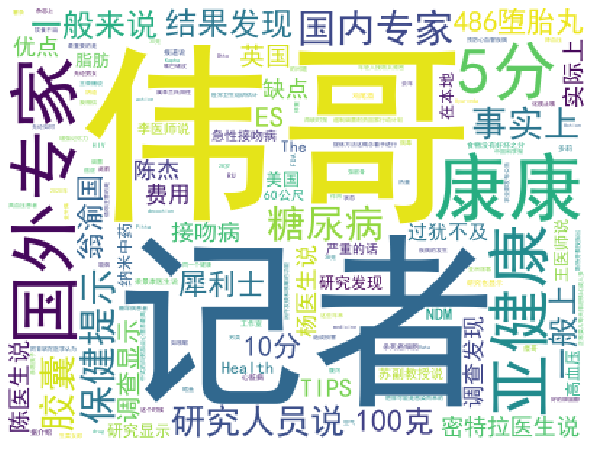

*Topic 1	- 市场 汇价 显示 增长 经济 银行 股市 我国 压力 日本


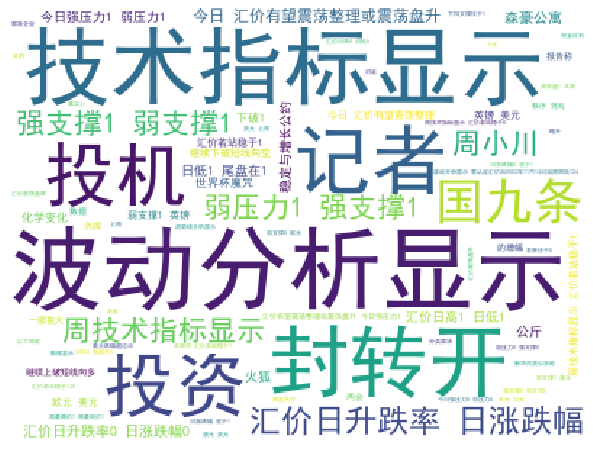

*Topic 2	- 比赛 球员 球队 nba 姚明 分钟 冠军 表现 对手 领先


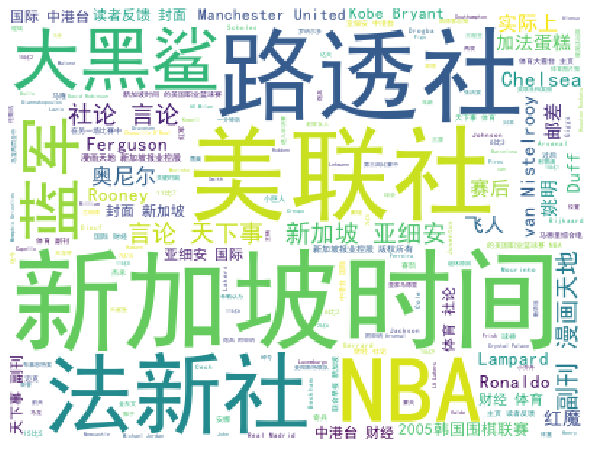

*Topic 3	- 电影 观众 音乐 导演 演出 作品 人物 这部 故事 专辑


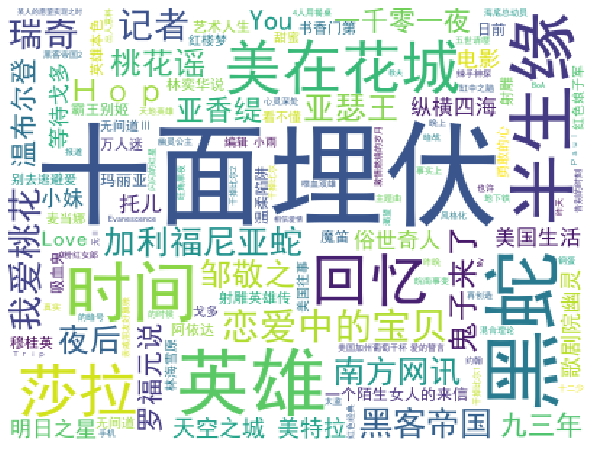

*Topic 4	- 工作 员工 企业 公司 记者 学生 能力 时间 希望 一种


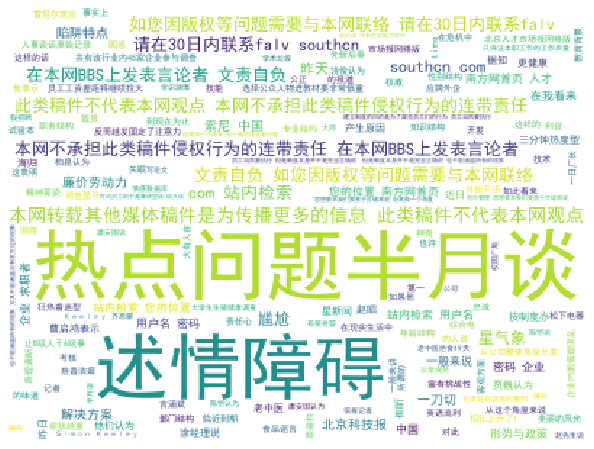

*Topic 5	- 中国 市场 公司 发展 企业 技术 产品 行业 服务 业务


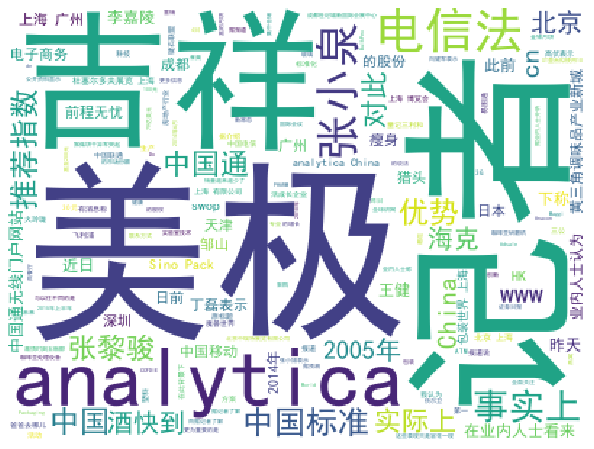

*Topic 6	- 手机 公司 电脑 用户 微软 病毒 软件 游戏 网络 网站


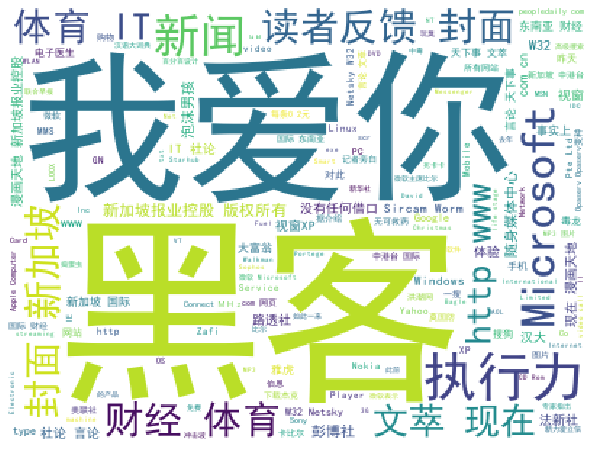

*Topic 7	- 食品 生产 产品 检测 食品安全 添加剂 销售 加工 记者 消费者


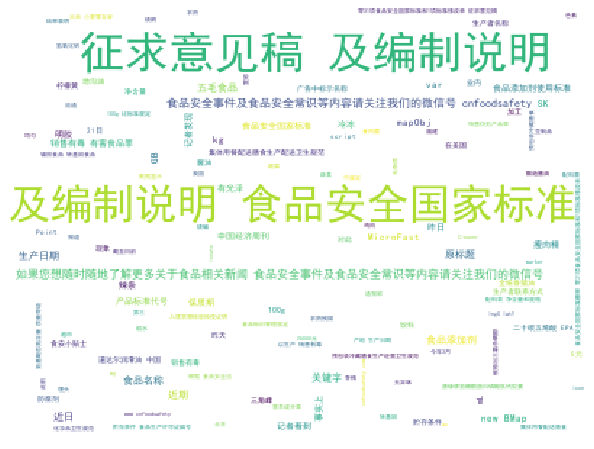

*Topic 8	- 太空 地球 美国 科学家 研究 人类 发现 飞行 土卫六 植物


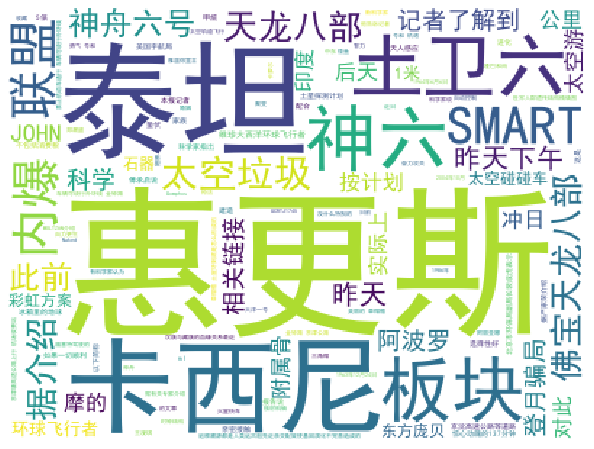

*Topic 9	- 食品安全 管理 工作 监管 企业 食品 国家 相关 社会 质量


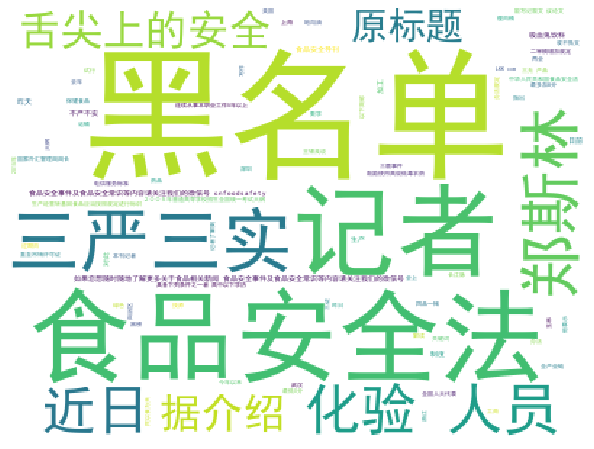

*Topic 10	- 单位 组屋 万元 公寓 价格 市场 售价 推出 项目 汽车


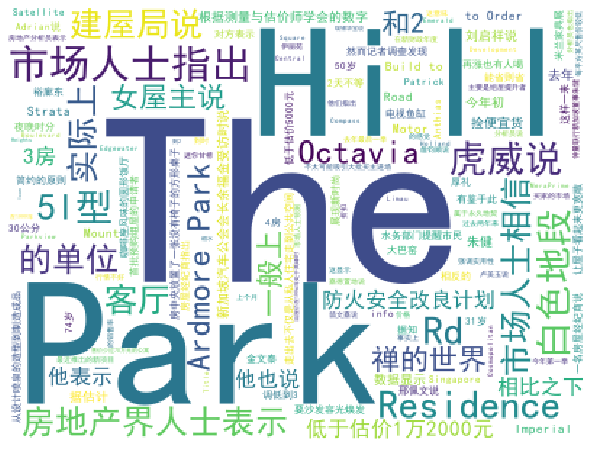

In [14]:
doc_topic = model.doc_topic_
topics_most_pr = doc_topic.argmax(axis = 1)
texts = df_train_n['content'].values

%run draw_wordcloud.py

for topic_idx in range(n_topics):
    print(topic_top_n_words[topic_idx])
    long_string = ','.join(list(np.array(texts)[topics_most_pr == topic_idx]))
    draw_wordcloud(long_string, stpwrdlst, 400, 300)

# 2. Non-Negative Matrix Factorization

X = WH

    X is mxn
    W is mxk, k is number of latent topics
    H is kxn 

Refer to [`/codex/py/machine learning/source/10. Matrix Factorization/NMF.ipynb`]

In [15]:
from sklearn import decomposition

n_topics = 11

estimator = decomposition.NMF(n_components=n_topics, init='nndsvda', tol=5e-3) #  NNDSVDa（全部零值替换为所有元素的平均值）和 NNDSVDar（零值替换为比数据平均值除以100 小的随机扰动）
estimator.fit(X)
H = estimator.components_
W = estimator.transform(X)

W.shape, H.shape, doc_topic.shape, topic_word.shape

((1137, 11), (11, 49043), (1137, 11), (11, 49043))

NMF分解得到的W相当于doc_topic矩阵，H相当于topic_word矩阵

## 2.1 主题-单词（Topic-Word）分布

In [16]:
# 计算各主题Top-N个单词

topic_top_n_words_nmf = []

n = 10
for i, topic_dist in enumerate(H):  
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]  
    s = '*Topic {}\t- {}'.format(i, ' '.join(topic_words))
    print(s)
    topic_top_n_words_nmf.append(s)    

*Topic 0	- 股市 市场 我国 发展 证券市场 投资 改革 危机 分红 历史
*Topic 1	- 汇价 显示 增长 经济 支撑 压力 位于 短线 震荡 周线
*Topic 2	- 食品 食品安全 添加剂 生产 检测 标准 产品 月饼 国家标准 国家
*Topic 3	- 中国 市场 技术 3g 运营商 手机 发展 业务 服务 企业
*Topic 4	- 产品 选购 食用 购买 保存 颜色 饮料 蜂蜜 酱油 蔬菜
*Topic 5	- 电影 十面埋伏 中国 观众 张艺谋 导演 这部 故事 电视剧 影片
*Topic 6	- 公司 企业 员工 工作 部门 管理 培训 生产 简历 人才
*Topic 7	- 土星 地球 土卫六 比赛 研究 惠更斯 太空 美国 人类 科学家
*Topic 8	- 牛杂 记者 火锅店 销售 牛肉 检疫 柳州 冰冻 宰杀 罗福元
*Topic 9	- 有机 蔬菜 食品 农业 产品 消费者 维真 价格 农产品 企业
*Topic 10	- 公寓 单位 万元 组屋 售价 价格 市场 乳业 平方英尺 平均


# 2.2 查看隶属于特定主题的文档

*Topic 0	- 股市 市场 我国 发展 证券市场 投资 改革 危机 分红 历史


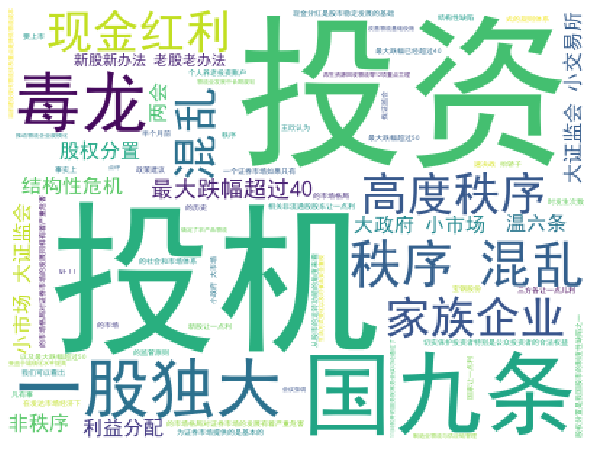

*Topic 1	- 汇价 显示 增长 经济 支撑 压力 位于 短线 震荡 周线


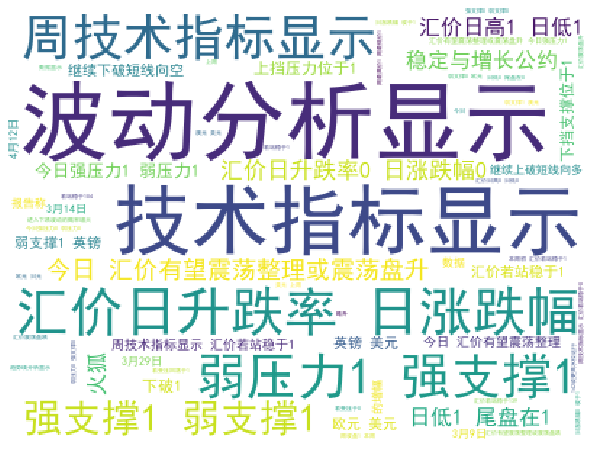

*Topic 2	- 食品 食品安全 添加剂 生产 检测 标准 产品 月饼 国家标准 国家


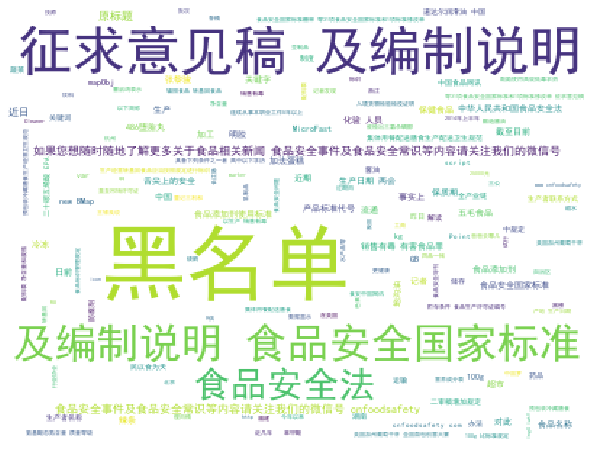

*Topic 3	- 中国 市场 技术 3g 运营商 手机 发展 业务 服务 企业


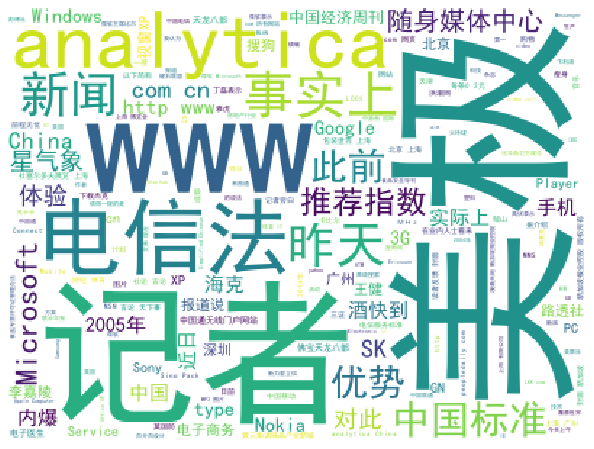

*Topic 4	- 产品 选购 食用 购买 保存 颜色 饮料 蜂蜜 酱油 蔬菜


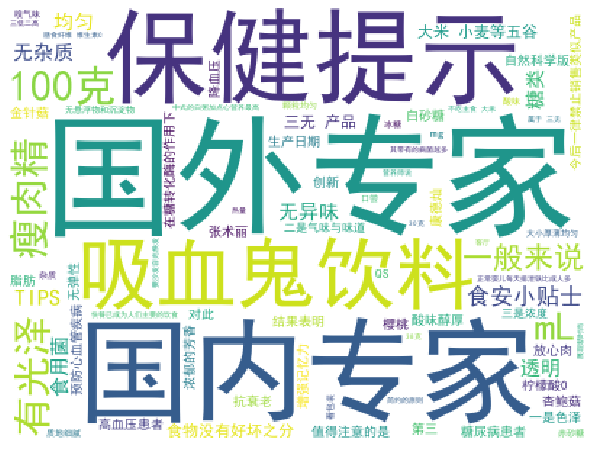

*Topic 5	- 电影 十面埋伏 中国 观众 张艺谋 导演 这部 故事 电视剧 影片


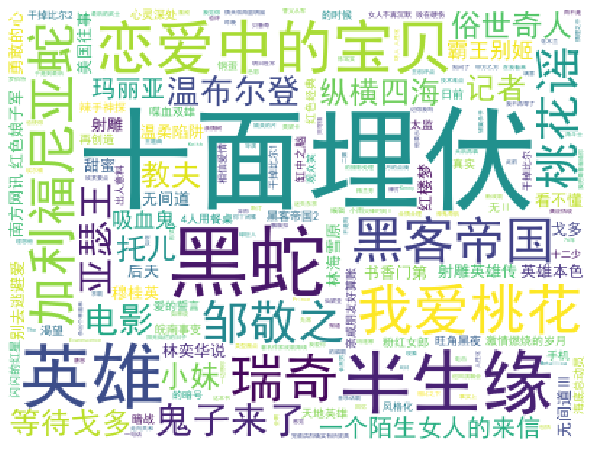

*Topic 6	- 公司 企业 员工 工作 部门 管理 培训 生产 简历 人才


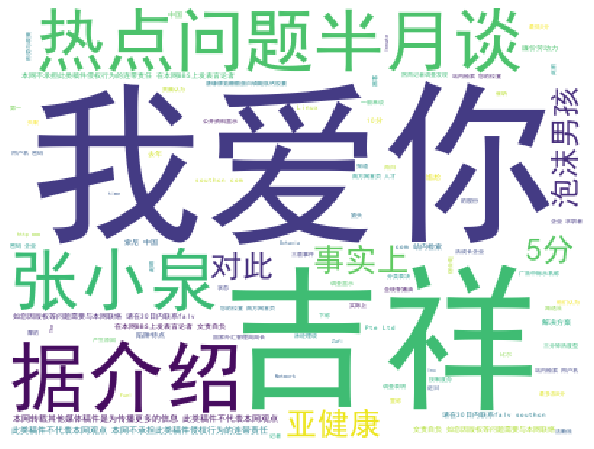

*Topic 7	- 土星 地球 土卫六 比赛 研究 惠更斯 太空 美国 人类 科学家


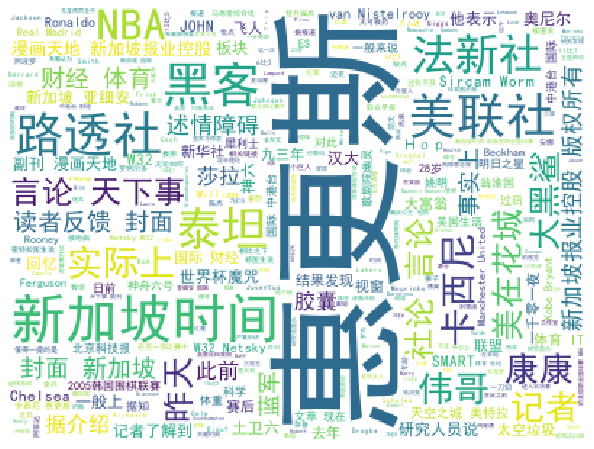

*Topic 8	- 牛杂 记者 火锅店 销售 牛肉 检疫 柳州 冰冻 宰杀 罗福元


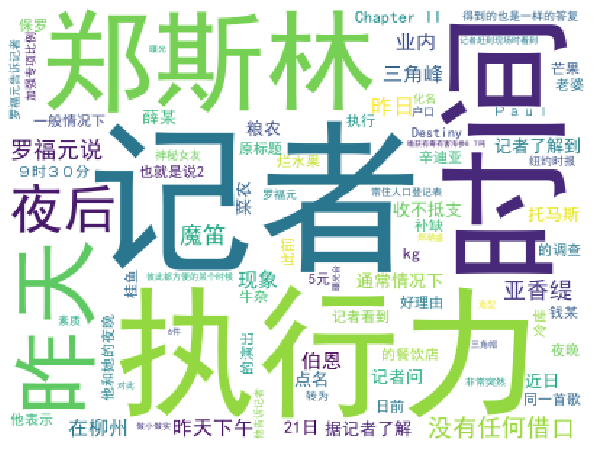

*Topic 9	- 有机 蔬菜 食品 农业 产品 消费者 维真 价格 农产品 企业


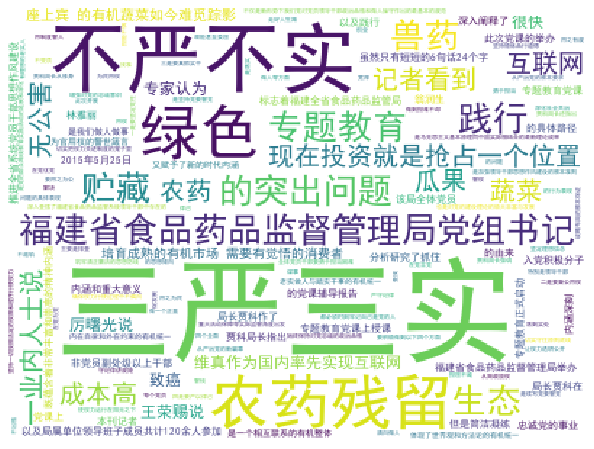

*Topic 10	- 公寓 单位 万元 组屋 售价 价格 市场 乳业 平方英尺 平均


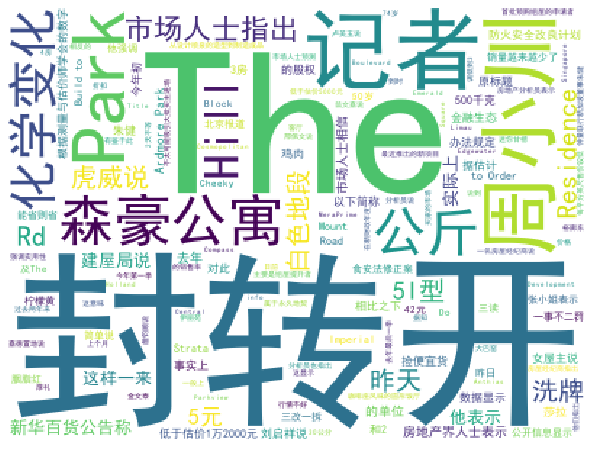

In [18]:
doc_topic = W
topics_most_pr = doc_topic.argmax(axis = 1)
texts = df_train_n['content'].values

%run draw_wordcloud.py

for topic_idx in range(n_topics):
    print(topic_top_n_words_nmf[topic_idx])
    long_string = ','.join(list(np.array(texts)[topics_most_pr == topic_idx]))
    draw_wordcloud(long_string, stpwrdlst, 400, 300)

# 3 Clustering

Clustering可以使用原始的DTM（Document-Term Matrix）矩阵或TF-IDF矩阵。对比效果，TF-IDF矩阵普遍优于DTM

## 3.1 计算TF-IDF矩阵

[`codex/py/NLP/TF-IDF.ipynb`]

X 为 DTM (document-term matrix), shape = (n_doc, n_word)

In [20]:
%run tf_idf_matrix.py
TF_IDF, IDF = tf_idf_matrix(X)

# 3.2 聚类

## 3.2.1 GMM (Gaussian mixture model)

[`codex/py/machine learning/source/9. Clustering/GMM.ipynb`]

[`codex/py/NLP/Topic Models.ipynb`]

## 3.2.2 K-Means

In [21]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=n_topics)
km.fit(TF_IDF)
labels = km.predict(TF_IDF)

for i, row in enumerate(km.cluster_centers_):
    print('===Center %d===' % (i+1))
    for idx in np.where(row > 5)[0]:
        print(idx, np.array(vocab)[idx], round(row[idx],3))

===Center 1===
637 400 18.543
2040 fans 33.254
4294 一抱 7.344
4423 一百块 7.344
4537 一身 5.552
4573 一阵 5.734
4575 一阵阵 6.651
4669 万元 7.097
4709 万是 7.344
4986 上台 13.301
5323 不在意 7.344
5403 不惜 5.552
5415 不慎 11.68
5480 不清 6.651
5511 不知 5.147
5538 不肯 5.84
5713 专程前往 7.344
5725 专辑 9.636
5891 丝毫 5.472
5935 两千多 7.344
5937 两千多名 7.344
6022 两点 6.091
6147 个子 7.344
6245 中国 18.965
6405 中文 29.409
6408 中文歌曲 14.688
6689 主办方 5.639
7122 买个 6.938
7219 争相 6.245
7908 人民币 13.12
7916 人气 17.203
8057 今欲 7.344
8170 代为 6.245
8196 代言 30.456
8619 传球 5.264
8716 伸出 6.428
8774 低于 8.506
9056 作风 5.734
9177 依旧 10.083
9277 俏皮 14.688
9322 保密 5.734
9631 假装 6.428
9672 做事 5.958
9766 偶像 11.104
10167 入侵 5.147
10252 全心全意 7.344
10272 全智贤 6.938
10348 八十万 7.344
10377 公主 6.428
10593 共识 5.958
10610 关子 7.344
10656 兴奋不已 6.651
10827 内地 63.948
11109 冰淇淋 12.855
11654 刁蛮 7.344
12383 剩余价值 7.344
12507 功夫 5.734
12682 助养 7.344
12720 劲歌热舞 7.344
13216 半点 6.651
13233 半钟 6.938
13403 卖力 6.651
13421 卖身契 7.344
13471 南海 12.855
13500 博得 6.651
13927 去年底 5.264

35296 相关 5.58
35338 相比 7.549
35565 眼花缭乱 6.651
35659 知情 5.398
36221 私下 5.958
36227 私募 13.877
36446 称拟 14.688
36851 第一 6.884
36876 第一家 5.472
36888 第一期 6.428
37033 第六 5.84
37082 等于 5.147
37133 筹资 6.938
37174 简称 18.285
37222 管理 14.809
37238 管理性 7.344
37613 紧俏货 7.344
38085 经营 10.449
38178 给出 16.416
38208 绝版 7.344
38477 缺钱 7.344
38523 网络 9.774
38555 网销 7.344
38655 置换 6.651
38785 美的 5.84
39204 联手 5.204
39343 股东 50.926
39344 股东会 7.344
39345 股东大会 26.603
39346 股东权益 20.815
39348 股价 22.557
39349 股份 24.73
39358 股本 6.938
39359 股权 74.606
39362 股票 5.041
39474 背后 9.803
39906 自有 11.469
40213 节节 6.651
40779 营业 5.472
40928 蒙牛 6.938
41390 表决 24.981
41391 表决权 6.938
41525 装进来 7.344
41559 西北 6.428
41835 解放 12.855
41841 解放街 7.344
41858 解释 11.778
41945 计提 7.344
41956 计算 8.799
41992 认同 5.329
42075 记者 7.876
42187 证券 5.329
42193 证券法 7.344
42207 证监会 5.84
42218 评估 77.189
42924 账面 6.651
42955 质疑 9.636
42994 购买 30.194
43013 购物中心 5.958
43016 购置 6.938
43131 资产 104.306
43134 资产重组 14.688
43143 资本 14.337
43166 资金 7.635
431

37456 精密 6.651
37458 精密机械 7.344
37565 系统工程 6.245
37889 纽约时报 6.938
37923 组建 5.264
38197 绝密 7.344
38589 罗布泊 7.344
38698 美国 15.117
39166 职务 5.472
39258 聚焦 67.002
39470 背信弃义 7.344
39539 胡子 6.938
39627 能量 34.948
39683 脚下 5.472
39855 自力更生 22.032
39859 自动控制 13.877
39924 自然界 6.245
39963 自行 5.264
40124 艰巨 6.428
40127 艰辛 6.245
40338 苏美 7.344
40339 苏联 44.993
40340 苏联政府 14.688
40412 英国 11.041
40532 草原 6.428
40555 荒漠 7.344
40757 菩萨 6.938
40872 著名 10.783
41054 蘑菇云 7.344
41276 行家里手 7.344
41279 行径 13.877
41334 衡阳 7.344
41397 表态 5.958
41495 裂变 51.407
41509 装料 7.344
41510 装有 5.734
41511 装核 14.688
41518 装着 6.938
41532 裤带 7.344
41602 西格 7.344
41636 西部 10.658
41713 见解 6.091
41735 观测台 7.344
41823 解决 6.945
41836 解放以来 7.344
41947 计数器 7.344
41956 计算 8.799
41982 订购 5.329
42016 讨好 6.245
42020 讨论会 6.651
42064 记录下来 6.938
42098 讲话 11.469
42137 论断 6.938
42163 设计方案 6.938
42173 访美 7.344
42300 试生产 6.938
42318 试验 90.213
42320 试验场 22.032
42321 试验室 6.938
42509 说道 6.651
42621 调来 7.344
42655 谈判 18.273
42922 账是 7.344
43140 资

17156 培育 10.293
17193 基本一致 6.938
17256 堵塞 6.245
17265 塑盖 7.344
17267 塑胶套 7.344
17345 增加 11.224
17355 增塑剂 7.344
17356 增多 11.278
17366 增白剂 13.877
17446 声音 8.799
17504 复原 5.639
17509 复合 5.734
17538 夏天 10.944
17540 夏季 15.793
17567 外包装 5.84
17582 外型 5.84
17584 外壳 5.958
17601 外来 10.796
17634 外表 29.199
17635 外观 37.303
17651 外部 5.472
17672 多为 6.651
17777 多汗 7.344
17920 大匙 6.938
17957 大型商场 6.938
18000 大小 13.907
18003 大尾 7.344
18054 大料 14.688
18112 大片 5.84
18122 大白 7.344
18123 大白菜 7.344
18138 大米 73.093
18146 大而薄 7.344
18165 大茴香 7.344
18309 天津 5.398
18315 天然 14.978
18338 天蓝色 7.344
18384 太浅 7.344
18389 太白粉 7.344
18414 太长 6.428
18456 失效 6.091
18486 头发 5.398
18493 头时 7.344
18495 头晕 6.245
18761 奶中 6.651
18767 奶制品 6.245
18769 奶已 7.344
18773 奶汁 7.344
18775 奶液 14.688
18780 奶瓶 6.651
18818 好坏 24.981
18843 好看 5.472
18858 如为 6.651
18876 如头 7.344
18894 如枣 7.344
18900 如给 7.344
18912 如重 14.688
18921 如鲜 7.344
19065 婴儿 5.147
19068 婴幼儿 5.472
19114 孔雀 7.344
19142 字迹 6.938
19152 存养 14.688
19156 存放 11.915
19162 存氧 7

33266 特别 15.301
33288 特定条件 6.938
33306 特有 24.981
33512 猪肉 69.277
33513 猪肝 7.344
33741 环境 15.513
33746 环境污染 6.651
33821 现象 21.93
33836 玻璃 5.552
33837 玻璃包装 7.344
33841 玻璃瓶 6.938
33873 珠状 7.344
33975 琳琅满目 6.938
33985 瑕疵 6.651
34035 瓶内 7.344
34036 瓶口 13.877
34037 瓶子 6.428
34038 瓶底 6.938
34039 瓶盖 22.032
34040 瓶装 19.283
34041 瓶身 14.688
34061 甘蔗 27.754
34076 甜味 12.855
34077 甜味剂 5.958
34080 甜度 7.344
34085 甜腻 6.938
34092 生产 17.771
34095 生产厂家 12.182
34105 生产日期 32.388
34123 生吃 14.688
34129 生命危险 6.651
34141 生存 14.009
34161 生意 5.398
34162 生成 5.734
34179 生水 22.032
34180 生活 6.264
34222 生着 7.344
34234 生虫 14.688
34239 生长 28.674
34240 生长发育 5.734
34272 用干 7.344
34282 用手 6.091
34292 用牙 7.344
34295 用眼 7.344
34298 用纸 14.688
34307 用途 10.185
34309 用量 5.958
34370 甲状腺 13.301
34380 甲醛 6.938
34382 甲鱼 7.344
34632 界线 6.428
34642 留在 5.398
34680 略带 7.344
34692 番茄 6.651
34694 番薯 6.938
34695 畸变 7.344
34696 畸形 12.855
34707 疏通 6.938
34736 疲劳 5.734
34749 疾病 7.606
34780 病死 13.301
34781 病死猪 6.938
34809 症状 8.647
34836 痢疾杆菌 7

47998 饲养 5.552
48001 饲料 21.316
48011 饺子 7.344
48012 饼干 5.84
48023 馊味 6.938
48028 馒头 6.091
48093 首选 5.552
48105 香味 35.039
48106 香料 12.182
48110 香气 18.273
48112 香油 6.651
48126 香精 5.639
48133 香蕉 19.952
48306 骗钱 7.344
48311 骤然 7.344
48316 骨密度 6.938
48325 骨肉分离 7.344
48341 高中档 7.344
48356 高低不平 7.344
48460 高温 23.83
48491 高粱 6.938
48526 高超 6.245
48591 鱼体 29.376
48596 鱼时 6.651
48597 鱼有 7.344
48603 鱼泡 7.344
48608 鱼类 16.917
48612 鱼肉 6.245
48613 鱼腥味 7.344
48618 鱼鳃 7.344
48619 鱼鳞 13.877
48653 鲍鱼 6.245
48656 鲜亮 6.938
48657 鲜口 7.344
48660 鲜嫩 6.938
48662 鲜明 12.182
48666 鲜活 6.428
48667 鲜牛奶 6.938
48669 鲜红色 7.344
48670 鲜美 20.815
48674 鲜蛋 14.688
48677 鲜贝 7.344
48678 鲜香 7.344
48679 鲜鱼 29.376
48686 鳃色 7.344
48690 鳝鱼 7.344
48691 鳞片 22.032
48703 鸡肉 40.141
48708 鸡蛋 36.427
48773 麸星少 7.344
48774 麸皮 14.688
48775 麸醋 22.032
48835 黄清 7.344
48840 黄瓜 7.344
48848 黄绿色 7.344
48850 黄色 23.359
48854 黄花鱼 7.344
48859 黄褐 7.344
48860 黄褐斑 7.344
48861 黄褐色 6.938
48862 黄豆 7.344
48879 黏在 6.938
48881 黏性 7.344
48882 黏稠度 7.344
48896 黑块

39030 而今 6.651
39051 而成 5.734
39137 耸立 7.344
39187 联合 7.988
39192 联合开发 6.651
39201 联想 5.84
39290 肉眼 12.855
39494 胎死腹中 6.428
39723 脱离 5.734
39786 腰部 6.428
40064 舞蹈 5.398
40067 航天 12.182
40073 航天局 6.651
40084 航空局 7.344
40135 色彩斑斓 7.344
40409 英勇 6.651
40534 草帽 14.688
40631 荷兰 18.162
40872 著名 7.189
40909 蒂安 7.344
41146 蛰伏 13.877
41301 行星 27.754
41426 表面 43.235
41598 西方 5.147
41734 观测 48.729
41736 观测站 7.344
41737 观测网 7.344
41738 观测者 7.344
41740 观点 8.647
41744 观赏 16.656
41768 视为 9.892
41781 视线 5.84
41806 角度 8.172
41833 解开 6.651
41936 计划 46.218
42063 记录 11.682
42065 记录在案 6.428
42075 记者 15.752
42151 设定 5.329
42200 证据 15.793
42239 评选 5.552
42395 该次 6.651
42681 谜团 6.938
43104 费解 6.938
43267 赤道 6.651
43278 赫里斯 7.344
43323 走马观花 6.938
43389 起步 5.552
43394 起源 12.491
43481 越低 6.428
43493 越大 5.639
43528 越高 5.398
43574 跋涉 7.344
43611 跟踪 5.472
43672 路过 6.938
43708 踏进 6.428
43756 身影 5.552
43829 轨迹 6.651
43830 轨道 23.359
43945 轰击 6.938
44008 较亮 7.344
44019 较弱 5.958
44139 边缘 5.204
44261 过程 14.595
44333 运行 1

31534 活动 12.803
32590 激情时刻 11.016
33832 玲珑 9.976
33930 球队 5.178
34942 白酒 36.654
34945 白金 9.641
36762 竞猜 13.301
38023 经典 5.204
39353 股市 5.398
40504 茅台 9.976
40807 营销 19.606
40890 葡萄酒 12.855
40903 董酒 18.36
41253 行业 5.118
41281 行情 5.472
41919 警惕 5.958
42919 账号 6.938
45446 酒业 6.428
46073 销量 7.057
47894 食品饮料 6.651
48577 魔咒 24.284
===Center 9===
49 10 8.988
50 100 6.766
111 12 16.74
165 14 6.655
189 15 9.16
215 16 6.482
237 17 10.037
295 19476 7.344
310 20 5.138
390 25 13.808
482 30 5.549
579 350 6.428
590 3600 11.68
636 40 13.768
829 60 14.62
1028 80 7.361
1191 94 5.147
1341 app 7.344
4032 一两 6.651
4070 一事 5.472
4085 一份 7.725
4086 一伐 7.344
4090 一位 24.382
4182 一块 20.165
4532 一路 5.398
4566 一长 6.938
4650 万亩 99.761
4671 万公里 6.091
4683 万吨 23.83
4697 万宁 7.344
4922 三边 7.344
4961 上书 6.938
5151 下属 16.416
5210 下达 6.651
5275 不利于 5.472
5313 不含 6.938
5513 不知情 11.68
5521 不种 7.344
5621 不顺 6.428
5857 东方 30.88
5908 两个 5.862
5921 两会 5.639
5924 两侧 70.703
5985 两广 7.344
6003 两旁 12.855
6418 中旬 5.639
6469 中称 5.63

7349 二级 11.915
7367 于事无补 6.938
7386 亏损 25.733
7401 互为条件 7.344
7421 互补性 6.651
7574 交换 5.639
7578 交易 8.696
7586 交易所 54.82
7671 产品设计 5.734
7684 产物 5.958
7790 人为 5.552
7892 人文 6.428
8154 付出 14.705
8173 代价 15.611
8188 代表 6.805
8357 任何一方 7.344
8394 企业 10.647
8400 企业家 6.091
8830 低迷 27.36
8890 体系 37.307
9149 供求 6.245
9325 保护 10.855
9363 保证 7.756
9419 信心 7.82
9446 信托 6.245
9456 信用 5.552
9651 偏废 6.938
9668 偏颇 7.344
9680 做出 7.988
9751 健康 16.29
9807 储蓄 5.84
9896 充分发挥 5.204
9951 先找 6.938
10062 克服 10.796
10117 免税 20.815
10247 全局 6.428
10280 全流通 6.938
10417 公司 15.859
10565 共同点 6.938
10583 共生 6.938
10587 共荣 7.344
10623 关系 20.712
10638 关键性 5.958
10733 具体做法 7.344
10741 具体表现 6.428
10747 典型 5.093
10775 养老 46.555
10778 养老金 6.938
10793 兼容 23.83
10826 内在 17.519
10892 内部 11.982
10918 再取 6.938
10960 冒险 10.796
11156 冲突 26.322
11168 决心 5.264
11173 决策 5.093
11235 净土 7.344
11365 几千年 22.032
11385 几年 12.144
11423 几起几落 7.344
11532 出台 8.747
11619 出路 6.428
11676 分割 6.938
11702 分布 5.147
11719 分散化 14.688
11760 分红 137.396

47295 非国有经济 7.344
47326 非流通股 27.754
47327 非现金 7.344
47365 面对 19.965
47582 顾问公司 6.428
47705 频率 5.472
47733 额度 19.283
47798 风险 39.032
48087 首要 5.958
48362 高出 9.636
48410 高度 79.151
48465 高点 57.344
48549 高风险 5.958
48972 鼓励 8.647
===Center 11===
667 430 6.245
702 470 6.938
759 52 5.204
769 527 7.344
781 543 7.344
787 550 6.651
871 638 6.938
4052 一个劲地 6.938
4060 一个桶 7.344
4061 一中 33.254
4119 一到 13.301
4163 一名 7.212
4206 一天到晚 7.344
4222 一家 6.925
4260 一年级 6.938
4416 一生 5.398
4503 一视同仁 13.301
4542 一辆 5.147
4804 三四 7.344
4878 三河 7.344
5038 上海 18.213
5151 下属 5.472
5233 不乏 5.204
5261 不像 5.84
5306 不合理 11.278
5623 不顾 6.091
5650 专业 7.052
5921 两会 11.278
5956 两地 6.245
6090 严格训练 7.344
6154 个案 6.245
6230 中南大学 7.344
6355 中学 10.408
6362 中小学 5.84
6367 中层 6.245
6485 中考 7.344
6556 丰对 7.344
6599 临近 6.091
6721 主抓 7.344
6812 久久 6.651
6822 义务教育 7.344
7101 书本 5.639
7338 二流 7.344
7348 二类 6.651
7713 京冀 7.344
7719 京报 12.855
7848 人大代表 6.245
8054 今晚 5.472
8366 任地 7.344
8479 优厚 6.651
9319 保定 7.344
9369 保送 20.815
9556 借读

*Topic 0	- 娜拉 内地 歌迷 韩国 fans 酬劳 代言 广场 中文 建国
*Topic 1	- 食品 中国 公司 企业 市场 记者 产品 工作 生产 手机
*Topic 2	- 乳业 新华 百货 资产 夏进 评估 股权 万元 宁夏 公司
*Topic 3	- 原子弹 核武器 试验 毛泽东 赫鲁晓夫 235 爆炸 中国 聚焦 核试验
*Topic 4	- 选购 保存 食用 颜色 色泽 酱油 异味 均匀 腐竹 光泽
*Topic 5	- 土星 惠更斯 土卫六 泰坦 地球 卡西尼 大气 探测 生命 探测器
*Topic 6	- 汇价 短线 支撑 周线 震荡 增长 位于 均线 整理 概率
*Topic 7	- 世界杯 白酒 魔咒 a股 营销 董酒 宋河 竞猜 下跌 葡萄酒
*Topic 8	- 纸浆 海南省 造林 浆纸 公路 林业局 金海 万亩 纸浆厂 林业
*Topic 9	- 股市 我国 证券市场 市场 发展 投资 制度性 分红 改革 投机
*Topic 10	- 北京 高考 学生 河北 考生 分数 香河 录取 分数线 大学


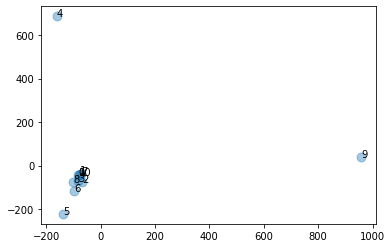

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
C_2 = pca.fit_transform(km.cluster_centers_)
plt.scatter([C_2[:,0]], [C_2[:,1]], s=80, alpha = .4)
    
# 计算各聚类中心的Top-N个单词
topic_top_n_words_km = []

n = 10
for i, topic_dist in enumerate(km.cluster_centers_):  
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]  
    s = '*Topic {}\t- {}'.format(i, ' '.join(topic_words))
    print(s)
    topic_top_n_words_km.append(s)   
    plt.annotate(str(i),(C_2[i,0], C_2[i,1]))